In [7]:
import numpy as np
import pandas as pd
import pandas_profiling
import scipy.stats
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
data = pd.read_excel("DAB12.xlsx", sheet_name="exo")

data = data.drop(['Dist_DAB',\
                  'E1_elec', 'E1_polar', 'E1_ct',\
                  'E2_elec', 'E2_Pauli', 'E2_polar', 'E2_ct', 'E2_solv',\
                  'E3_elec', 'E3_disp', 'E3_ct', 'E3_solv'], axis = 1)

X = data.drop(['Name', 'Class', 'deltaG'], axis = 1)

y = data['deltaG']

accuracy_df = pd.DataFrame(columns =['Model'])


In [9]:
####################
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [10]:
####################
def compute_accuracy(dataset, model, data_iterations, cv_iterations):
    # For each 'data_iteration', sample a new subset of the 'other' trajectories to be used in a 1:1 ratio set with the 'quick exo' trajectories
    average_scores = []

    # Also keep track of all cv scores in order to compute confidence interval
    all_scores = []

    for i in range(0, data_iterations):

        # Do N fold cross validation on selected training set
        cv_scores = cross_val_score(model, X, y, cv=cv_iterations, scoring='neg_mean_squared_error')
        accuracies = []
        for i in range(len(cv_scores)):
            cv_scores[i] = np.abs(cv_scores[i])
            accuracies.append(np.sqrt(cv_scores[i]))

        # Average the cross validation scores, record it
        avg_score = np.mean(accuracies)
        average_scores.append(avg_score)

        # Add each cv score to 'all_scores'
        for score in average_scores:
            all_scores.append(score)

    # Compute the average score over all data iterations (samplings of 'other' trajectories for the training set)
    overall_average_score = np.mean(average_scores)
    #print("RMSE: ", overall_average_score)

    # Compute confidence interval of the accuracies
    mean1, CI_lower1, CI_upper1 = mean_confidence_interval(all_scores)
    #print("RMSE Upper Bound: " + str(CI_upper1) + '\n' + "RMSE Lower Bound: " + str(CI_lower1))

    # Return overall average accuracy
    return overall_average_score


In [11]:
####################
#Create Regressor
model = RandomForestRegressor(n_estimators=120)

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'RandomForest', 'RMSE': accuracy}, ignore_index=True)

####################
#Create Regressor
model = DecisionTreeRegressor()

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'DecisionTree', 'RMSE': accuracy}, ignore_index=True)

####################
#Create Regressor
model = Lasso()

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'LASSO', 'RMSE': accuracy}, ignore_index=True)

####################
#Create Regressor
model = linear_model.ElasticNet()

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'Elastic-Net', 'RMSE': accuracy}, ignore_index=True)

####################
#Create Regressor
kernel = 1.0 * RBF(1.0)
model = GaussianProcessRegressor(kernel=kernel)

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'GPR', 'RMSE': accuracy}, ignore_index=True)

####################
#Create Regressor
model = SVR(kernel='linear')

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'SVR-linear', 'RMSE': accuracy}, ignore_index=True)

####################
#Create Regressor
model = SVR(kernel='rbf')

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'SVR-rbf', 'RMSE': accuracy}, ignore_index=True)

####################
#Create Classifier
model = Ridge()

#Call compute accuracy function
accuracy = compute_accuracy(data, model, data_iterations=5, cv_iterations=20)

#Track accuracy of each model in a dataframe
accuracy_df = accuracy_df.append({'Model': 'Ridge', 'RMSE': accuracy}, ignore_index=True)

####################
print(accuracy_df)


          Model      RMSE
0  RandomForest  0.775966
1  DecisionTree  0.930592
2         LASSO  0.868602
3   Elastic-Net  0.840021
4           GPR  5.723556
5    SVR-linear  0.974468
6       SVR-rbf  1.430747
7         Ridge  0.875123


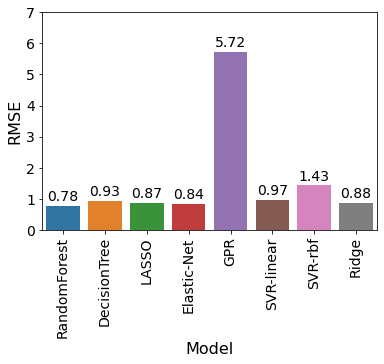

In [17]:
%matplotlib inline
####################
splot=sns.barplot(x="Model", y="RMSE", data=accuracy_df)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9),
                   fontsize=14,
                   textcoords = 'offset points')
plt.xticks(rotation=90, horizontalalignment="center")
plt.yticks(np.arange(0,8,1))
plt.tick_params(axis='x', labelsize=14)
plt.xlabel('Model', fontsize=16)
plt.tick_params(axis='y', labelsize=14)
plt.ylabel('RMSE', fontsize=16)
plt.show()
